In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from madxtools.air_scattering import *
import requests
from scipy.optimize import curve_fit

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [2]:
with open('MWPC_quadrupole_scan_run.pickle', 'rb') as f:
    data = pickle.load(f)

with open('Quadrupole_scan_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

selector = "CPS.USER.MD3"

In [3]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

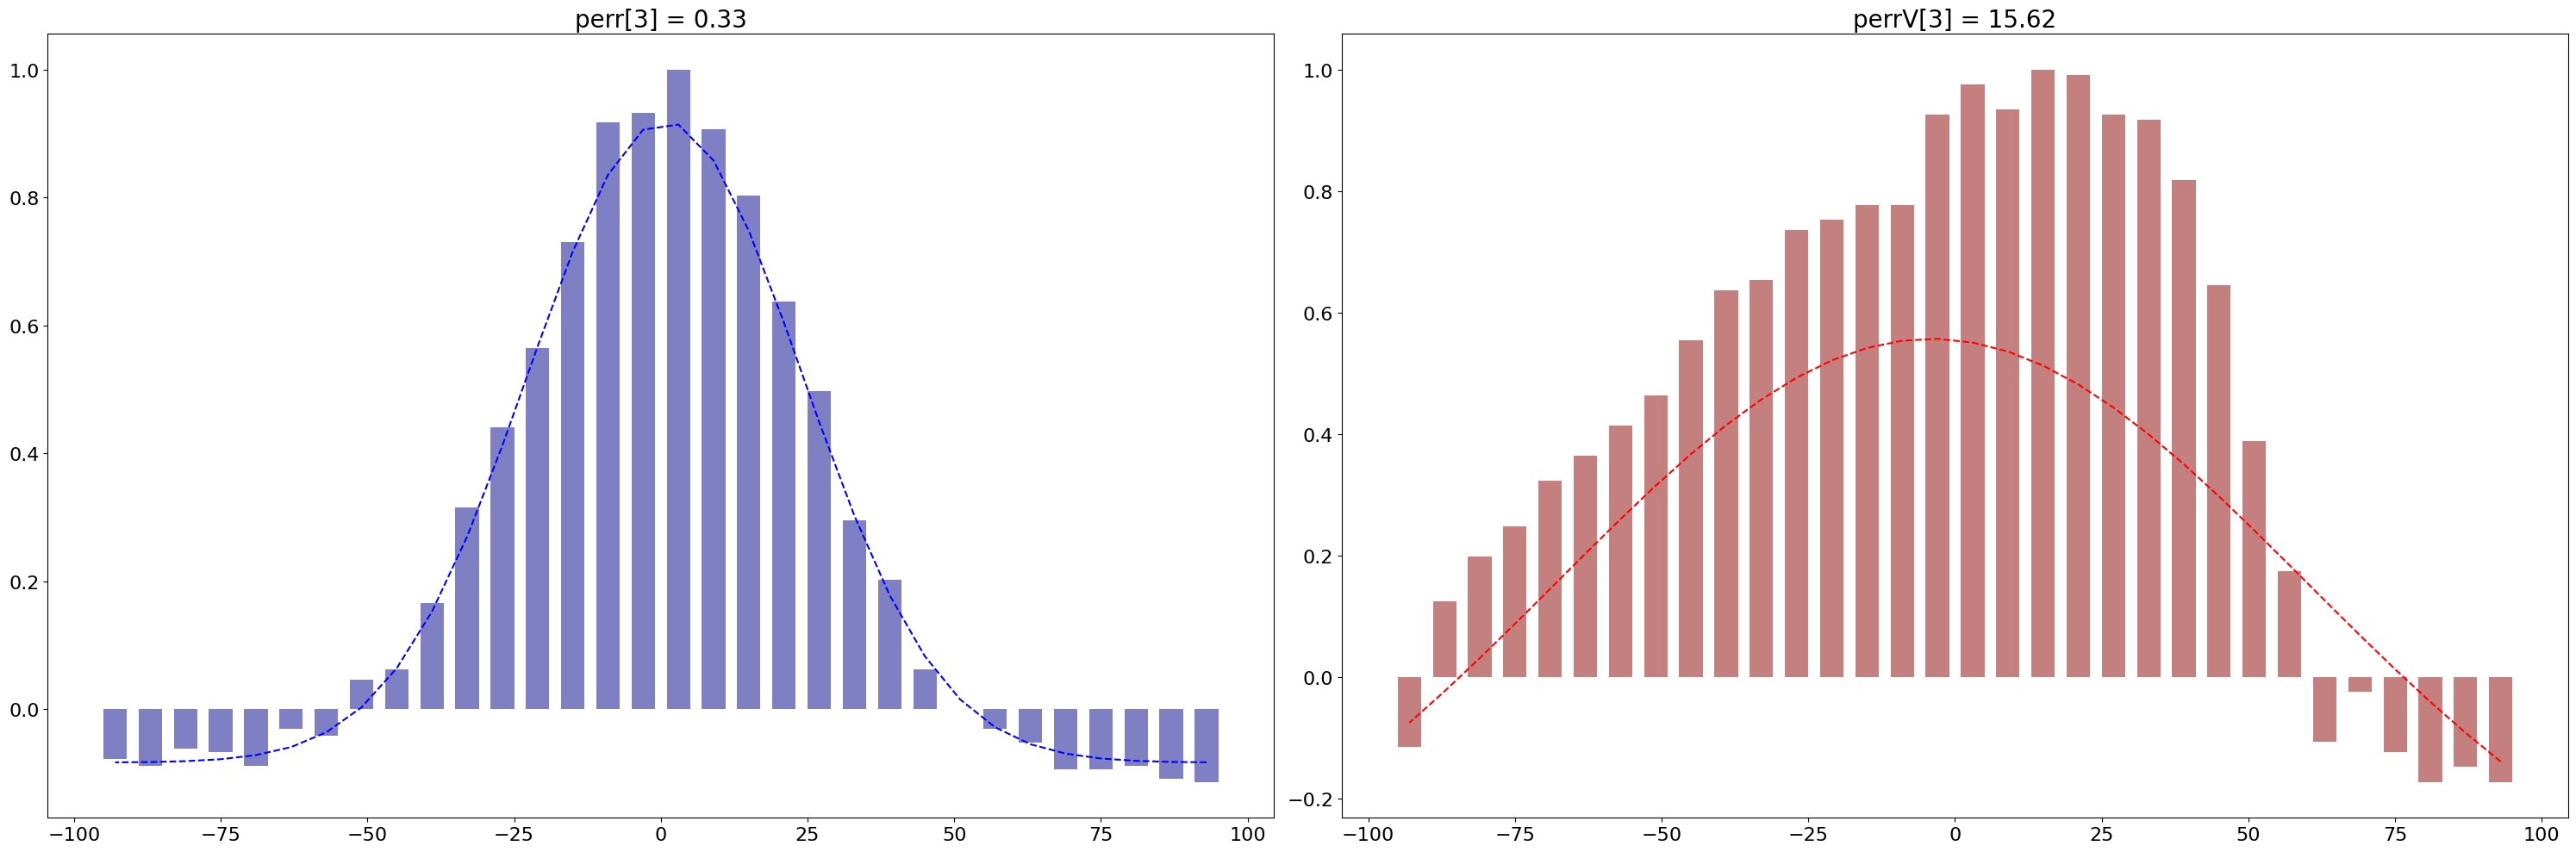

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(1,2, figsize=(30, 10), tight_layout=True)


target_timestamp = pd.to_datetime('2023-10-28 21:15:30.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)


data[data.selector == selector].timestamp.loc[element]

timestamp_measurement = data[data.selector == selector].timestamp.loc[element]

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax[0].bar(MWPC_wire, y/y.max(), width=4, color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
perr = np.sqrt(np.diag(pcov))
ax[0].plot(xs=MWPC_wire, ys=np.ones(len(MWPC_wire))*MWPC_wire.max(), zdir='z', c="b", ls="dashed", label=f"H FWHM = {fwhm_func(popt[3]):.1f} mm")
ax[0].set_title(f"perr[3] = {perr[3]:.2f}")
ax[0].plot(MWPC_wire, gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3]), c="b", ls="dashed", label=f"H FWHM = {fwhm_func(popt[3]):.1f} mm")

sigH_measurement = popt[3]

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax[1].bar(MWPC_wire, y/y.max(), width=4, color="darkred", alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
perr = np.sqrt(np.diag(pcovV))
y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
ax[1].plot(xs=np.ones(len(MWPC_wire))*MWPC_wire.min(), ys=MWPC_wire, c="r", ls="dashed", label=f"V FWHM = {fwhm_func(poptV[3]):.1f} mm")
ax[1].set_title(f"perrV[3] = {perr[3]:.2f}")
ax[1].plot(MWPC_wire, gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3]), c="r", ls="dashed", label=f"V FWHM = {fwhm_func(poptV[3]):.1f} mm")


sigV_measurement = poptV[3]


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

timestampH_list = []
timestampV_list = []
sigH_measurement_list = []
sigV_measurement_list = []
sigH_error_list = []
sigV_error_list = []

for timestamp in data.timestamp:

    target_timestamp = timestamp
    differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()
    element = closest_index
    MWPC_wire = np.linspace(93, -93, num=32)
    # data[data.selector == selector].timestamp.loc[element]
    timestamp_measurement = data[data.selector == selector].timestamp.loc[element]
    
    # Horizontal Measurement and Gaussian Fit
    try:
        y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
        popt, pcov = do_gaussian_fit(MWPC_wire, y)
        y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
        sigH_measurement = popt[3]
        sigH_measurement_list.append(sigH_measurement)
        perr = np.sqrt(np.diag(pcov))
        sigH_error_list.append(perr[3])
        timestampH_list.append(data[data.selector == selector].timestamp.loc[element])
    except:
        pass

    # Vertical Measurement and Gaussian Fit
    try:
        y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
        poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
        y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
        sigV_measurement = poptV[3]
        sigV_measurement_list.append(sigV_measurement)
        perrV = np.sqrt(np.diag(pcovV))
        sigV_error_list.append(perrV[3])
        timestampV_list.append(data[data.selector == selector].timestamp.loc[element])
    except:
        pass


In [6]:
df_quadrupoles

timestamp      selector  avg_flattop_Gauss      Ekin  \
0    2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
1    2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
2    2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
3    2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
4    2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
...                            ...           ...                ...       ...   
8491 2023-10-29 00:01:00.698238525  CPS.USER.MD3             2343.1  0.649985   
8492 2023-10-29 00:01:00.698238525  CPS.USER.MD3             2343.1  0.649985   
8493 2023-10-29 00:01:00.698238525  CPS.USER.MD3             2343.1  0.649985   
8494 2023-10-29 00:01:00.698238525  CPS.USER.MD3             2343.1  0.649985   
8495 2023-10-29 00:01:00.698238525  CPS.USER.MD3             2343.1  0.649985   

           Brho     current            magnet_name   type        k1  
0     35.828267  268.998108  F61.QFN007/MEAS.PULSE   Q74L  0.478035  
1     35.828267   88.007484  T08.QFN066/MEAS.PULSE  Q200L  0.068845  
2     35.828267  143.633881  F61.QDN014/MEAS.PULSE  Q120C  0.209318  
3     35.828267   78.104248  T08.QDN061/MEAS.PULSE  Q200L  0.061122  
4     35.828267  107.430038  T08.QFN021/MEAS.PULSE    QFL  0.195463  
...         ...         ...                    ...    ...       ...  
8491  16.420384   49.933018  F61.QFN021/MEAS.PULSE    QFL  0.198637  
8492  16.420384   66.304489  F61.QDN014/MEAS.PULSE  Q120C  0.210002  
8493  16.420384  123.683884  F61.QFN007/MEAS.PULSE   Q74L  0.479578  
8494  16.420384   35.832378  T08.QDN061/MEAS.PULSE  Q200L  0.061467  
8495  16.420384   40.348114  T08.QFN066/MEAS.PULSE  Q200L  0.069141  

[8496 rows x 9 columns]

(0.0, 120.0)

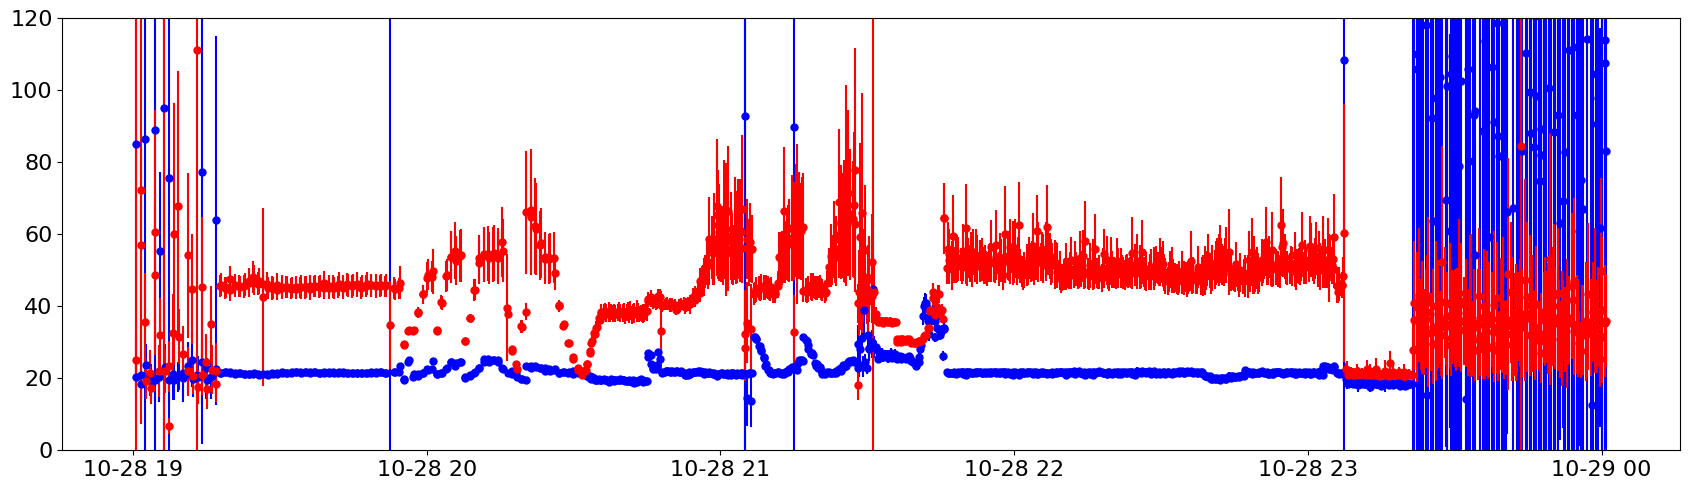

In [7]:
def sigma_func(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.errorbar(timestampH_list, sigH_measurement_list, sigH_error_list, ls="", marker="o", markersize=5, c="b")
ax.errorbar(timestampV_list, sigV_measurement_list, sigV_error_list, ls="", marker="o", markersize=5, c="r")

ax.set_ylim(0,120)
# ax.set_xlim(pd.to_datetime('2023-10-28 21:00:00.00'), pd.to_datetime('2023-10-28 21:30:00.00'))

(19658.79206019676, 19659.00069908565)

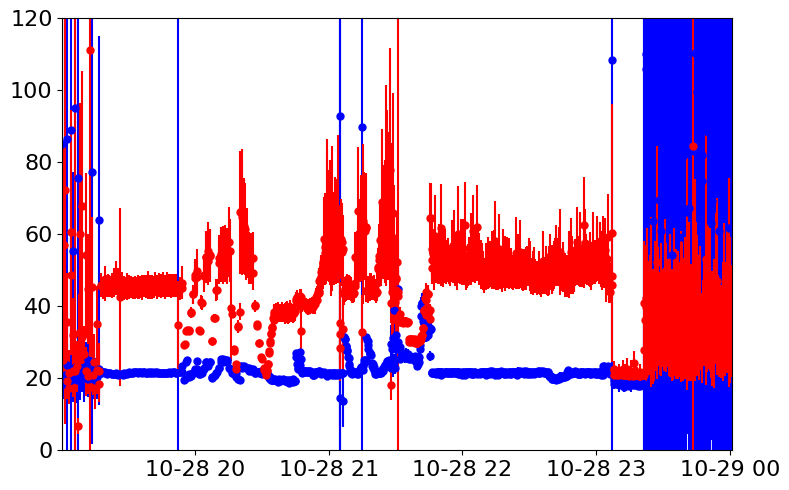

In [8]:
# start = pd.to_datetime('2023-10-28 19:52:00.00')
# end = pd.to_datetime('2023-10-28 20:15:00.00')

start = min(timestampH_list)
end = max(timestampH_list)

timestampH_series = pd.Series(timestampH_list)
sigH_measurement_series = pd.Series(sigH_measurement_list)
sigH_error_series = pd.Series(sigH_error_list)

timestampH_list_filtered = timestampH_series[(timestampH_series >= start) & (timestampH_series <= end)].tolist()
sigH_measurement_list_filtered = sigH_measurement_series[sigH_measurement_series[(timestampH_series >= start) & (timestampH_series <= end)].index].tolist()
sigH_error_list_filtered = sigH_error_series[sigH_error_series[(timestampH_series >= start) & (timestampH_series <= end)].index].tolist()

timestampV_series = pd.Series(timestampV_list)
sigV_measurement_series = pd.Series(sigV_measurement_list)
sigV_error_series = pd.Series(sigV_error_list)

timestampV_list_filtered = timestampV_series[(timestampV_series >= start) & (timestampV_series <= end)].tolist()
sigV_measurement_list_filtered = sigV_measurement_series[sigV_measurement_series[(timestampV_series >= start) & (timestampV_series <= end)].index].tolist()
sigV_error_list_filtered = sigV_error_series[sigV_error_series[(timestampV_series >= start) & (timestampV_series <= end)].index].tolist()


fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
ax.errorbar(timestampH_list_filtered, sigH_measurement_list_filtered, sigH_error_list_filtered, ls="", marker="o", markersize=5, c="b")
ax.errorbar(timestampV_list_filtered, sigV_measurement_list_filtered, sigV_error_list_filtered, ls="", marker="o", markersize=5, c="r")
ax.set_ylim(0,120)
ax.set_xlim(start, end)

In [9]:
# E_cin_per_nucleon = 2.0
# # Ion properties
# A = 208.0
# Z = 82.0
# N = 126.0
# charge = 54.0
# m_proton_GeV = 0.93828
# m_neutron_GeV = 0.93957
# m_electron_GeV = 0.000511
# m_u_GeV = 0.9315
# mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
# E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

# p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

# gamma = p/charge/0.938
# beta = np.sqrt(1-gamma**(-2))
# exn=1.5e-6
# eyn=1.5e-6
# ex = exn/(beta*gamma)
# ey = eyn/(beta*gamma)

# print(p/charge)
# print(f"gamma = {round(gamma,3)}")
# print(f"beta = {round(beta,3)}")
# print(f"p = {round(p/charge,3)} GeV/c")

# Brho = 3.33564*p/charge

In [10]:
# target_timestamp_list = []
# fwhmH_list = []
# fwhmV_list = []
# # Separate lists for each quadrupole k1 value
# quad_k1_values = {f"Quad_K1_{i+1}": [] for i in range(8)}  # Adjust the range if you have more or fewer quadrupoles


# iter = 0
# for t in timestampH_list_filtered:
#     print(f"{iter}/{len(timestampH_list_filtered)}")
#     iter += 1
#     selector = "CPS.USER.MD3"
#     target_timestamp = t

#     keys = ["F61.QFN007/MEAS.PULSE",
#             "F61.QDN014/MEAS.PULSE",
#             "F61.QFN021/MEAS.PULSE",
#             "F61.QDN030/MEAS.PULSE",
#             "T08.QFN021/MEAS.PULSE",
#             "T08.QDN023/MEAS.PULSE",
#             "T08.QDN061/MEAS.PULSE",
#             "T08.QFN066/MEAS.PULSE"]

#     quad_k1_at_targ_t = []
#     for index, key in enumerate(keys):
#         df_quadrupoles_key = df_quadrupoles[df_quadrupoles.magnet_name == key]

#         differences = (df_quadrupoles_key[df_quadrupoles_key.selector == selector].timestamp - target_timestamp).abs()
#         closest_index = differences.idxmin()
#         element = closest_index
#         quad_k1_at_targ_t.append(df_quadrupoles_key.k1.loc[element])
#         quad_k1_values[f"Quad_K1_{index+1}"].append(df_quadrupoles_key.k1.loc[element])


#     # Matched initial parameters 10 apr 2024
#     betx0 = 6.67479971e+01
#     alfx0 = -1.62722259e+01
#     Dx0 = 0.08552983
#     Dpx0 = 0.01723517
#     exn = 2.28304416e-05

#     bety0 = 3.76412474e+00
#     alfy0 = 7.03346313e-01
#     Dy0 = -0.00262435
#     Dpy0 = -0.00475684
#     eyn = 8.63495536e-06

#     sige = 0.0045

#     ex = exn/(beta*gamma)
#     ex_initial = ex
#     ey = eyn/(beta*gamma)
#     ey_initial = ey

#     with open('tempfile', 'w') as f:
#         madx = Madx(stdout=f,stderr=f)
#         madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

#     madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
#     madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)


#     # Quadrupoles
#     madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
#     madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
#     madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
#     madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
#     madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
#     madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
#     madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
#     madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

#     # Dipoles
#     madx.input("kBHZ1 = "+str(-0.04821227494)+";")
#     madx.input("kBHZ2 = "+str(0.04980753404)+";")
#     madx.input("kBHZ3 = "+str(0.02555487086)+";")
#     madx.input("kBHZ4 = "+str(-0.03515967369)+";")
#     madx.input("kBHZ5 = "+str(-0.03515967369)+";")

#     # Add the Air region
#     sequence = "f61t8_op"

#     p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
#     p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
#     add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

#     p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
#     p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
#     add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#     #t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
#     p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
#     p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
#     add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

#     p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
#     p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
#     add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

#     p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
#     p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
#     add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

#     p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
#     p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
#     add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

#     pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
#     len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
#     pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
#     add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

#     pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
#     len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
#     pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
#     add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


#     # add_hidden_marker(madx, sequence, 20, 100, steps)

#     madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
#     madx.input('BRHO      := BEAM->PC * 3.3356;')
#     madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
#     madx.use(sequence=sequence)

#     madx.input('''
#     SEQEDIT, sequence=f61t8_op;
#     SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
#     REMOVE, ELEMENT=SELECTED;
#     ENDEDIT;
#     ''')

#     # make thin
#     madx.use(sequence="f61t8_op")
#     madx.input('SEQEDIT, sequence=f61t8_op;')
#     madx.input('FLATTEN;')
#     madx.input('ENDEDIT;')
#     madx.use(sequence="f61t8_op")
#     madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
#     # madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
#     madx.use(sequence="f61t8_op")

#     twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="RP_run_3GeV.tfs").dframe()

#     madx.use(sequence=sequence)
#     madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
#     twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
#     twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

#     sigH = beam_size(twiss_scattered.loc['t08.xwcm103']['betx'], twiss_scattered.loc['t08.xwcm103']['dx'], twiss_scattered.loc['t08.xwcm103'].ex, sige, 1)
#     sigV = beam_size(twiss_scattered.loc['t08.xwcm103']['bety'], twiss_scattered.loc['t08.xwcm103']['dy'], twiss_scattered.loc['t08.xwcm103'].ey, sige, 1)

#     def fwhm_func(sigma):
#             return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

#     fwhmH = fwhm_func(sigH)
#     fwhmV = fwhm_func(sigV)

#     # print(f"{fwhmH*1000:.2f} mm")
#     # print(f"{fwhmV*1000:.2f} mm")

#     target_timestamp_list.append(t)
#     fwhmH_list.append(fwhmH)
#     fwhmV_list.append(fwhmV)

# # Create DataFrame with individual k1 columns
# data_dict = {
#     'Timestamp': target_timestamp_list,
#     'FWHM_H': fwhmH_list,
#     'FWHM_V': fwhmV_list,
# }
# data_dict.update(quad_k1_values)  # Merge the k1 values into the data dictionary

# df = pd.DataFrame(data_dict)

# # Display the DataFrame
# print(df.head())

In [14]:
import pickle

with open('df_simulation.pickle', 'rb') as f:
    df_sim = pickle.load(f)

(19658.8125, 19658.916666666668)

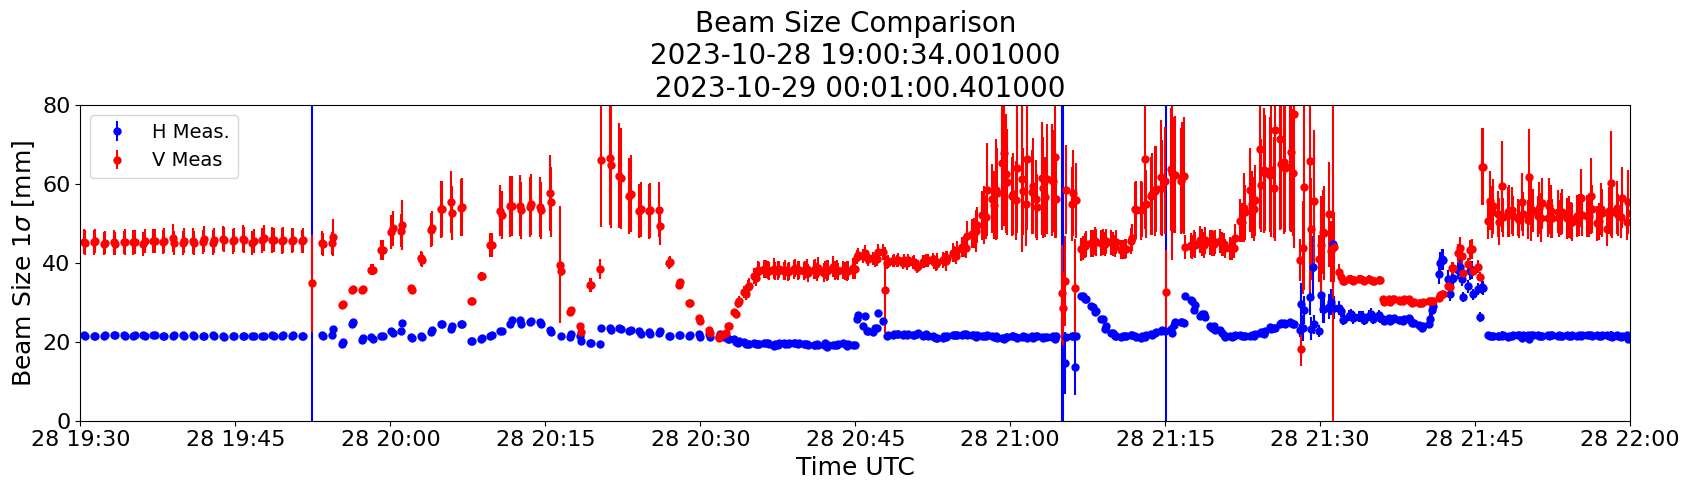

In [16]:
def sigma_func(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)


ax.errorbar(timestampH_list_filtered, sigH_measurement_list_filtered, sigH_error_list_filtered, ls="", marker="o", markersize=5, c="b", label="H Meas.")
ax.errorbar(timestampV_list_filtered, sigV_measurement_list_filtered, sigV_error_list_filtered, ls="", marker="o", markersize=5, c="r", label="V Meas")

ax.legend()
ax.set_ylim(0,80)

ax.set_xlabel("Time UTC")
ax.set_ylabel(r"Beam Size 1$\sigma$ [mm]")

ax.set_title(f"Beam Size Comparison\n{start}\n {end}")

ax.set_xlim(pd.to_datetime('2023-10-28 19:30:00.00'), pd.to_datetime('2023-10-28 22:00:00.00'))

In [17]:
with open('merged_df.pickle', 'rb') as f:
    merged_df = pickle.load(f)

(19658.8125, 19658.916666666668)

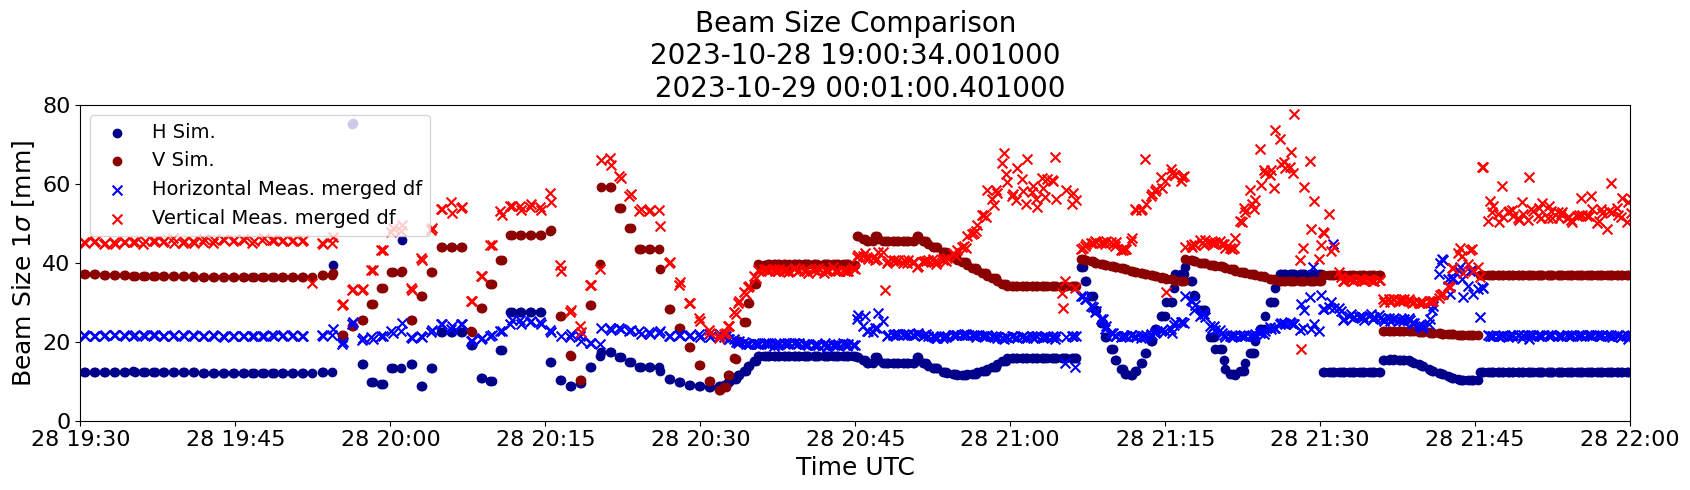

In [22]:
def sigma_func(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(df_sim.Timestamp, sigma_func(df_sim.FWHM_H)*1000, c="darkblue", label="H Sim.")
ax.scatter(df_sim.Timestamp, sigma_func(df_sim.FWHM_V)*1000, c="darkred", label="V Sim.")

# ax.errorbar(timestampH_list_filtered, sigH_measurement_list_filtered, sigH_error_list_filtered, ls="", marker="o", markersize=5, c="b", label="H Meas.")
# ax.errorbar(timestampV_list_filtered, sigV_measurement_list_filtered, sigV_error_list_filtered, ls="", marker="o", markersize=5, c="r", label="V Meas")


ax.scatter(merged_df.timestamp, merged_df.sigH_meas, label='Horizontal Meas. merged df', marker='x', s=50, c="b")
ax.scatter(merged_df.timestamp, merged_df.sigV_meas, label='Vertical Meas. merged df', marker='x', s=50, c="r")

ax.legend()
ax.set_ylim(0,80)

ax.set_xlabel("Time UTC")
ax.set_ylabel(r"Beam Size 1$\sigma$ [mm]")

ax.set_title(f"Beam Size Comparison\n{start}\n {end}")

ax.set_xlim(pd.to_datetime('2023-10-28 19:30:00.00'), pd.to_datetime('2023-10-28 22:00:00.00'))

In [23]:
merged_df.keys()

Index(['selector', 'timestamp', 'sigH_meas', 'sigV_meas', 'sigH_meas_error',
       'sigV_meas_error', 'F61.QDN014/MEAS.PULSE', 'F61.QDN030/MEAS.PULSE',
       'F61.QFN007/MEAS.PULSE', 'F61.QFN021/MEAS.PULSE',
       'T08.QDN023/MEAS.PULSE', 'T08.QDN061/MEAS.PULSE',
       'T08.QFN021/MEAS.PULSE', 'T08.QFN066/MEAS.PULSE'],
      dtype='object')

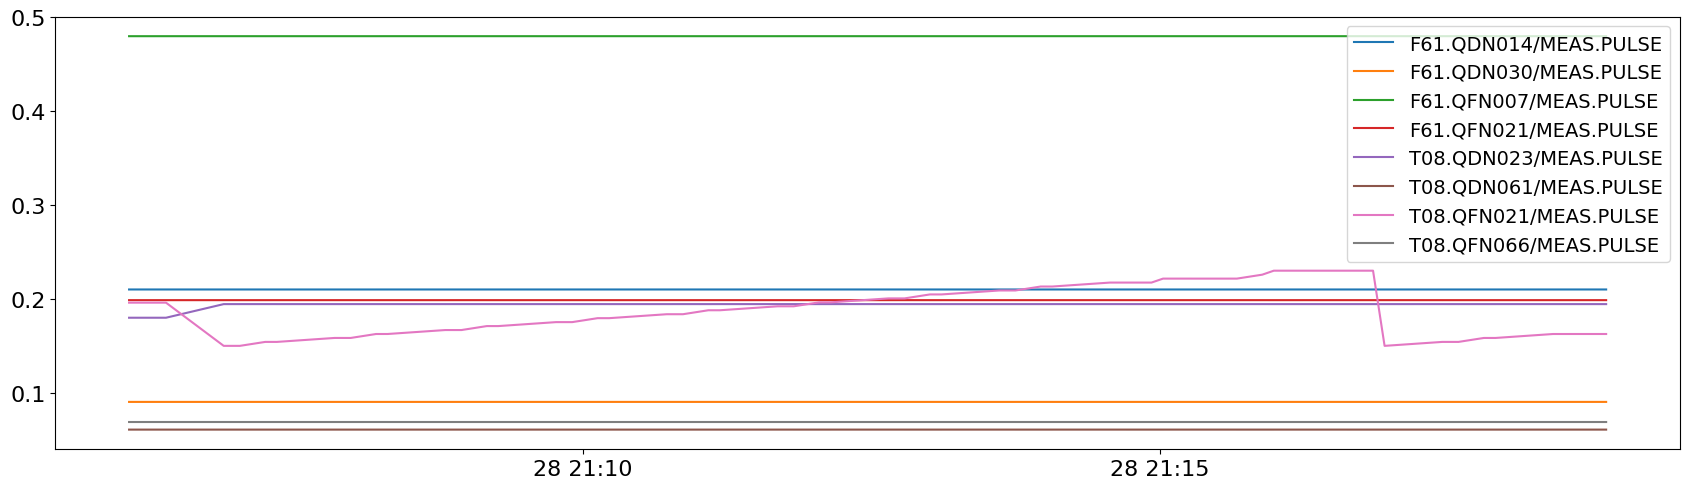

In [24]:
start = pd.to_datetime('2023-10-28 21:06:00.00')
end = pd.to_datetime('2023-10-28 21:19:00.00')

fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

magnet  = "T08.QFN066/MEAS.PULSE"
for magnet in merged_df_filtered.columns[6:]:
    ax.plot(merged_df_filtered.timestamp, merged_df_filtered[magnet],label=f"{magnet}")
ax.legend()

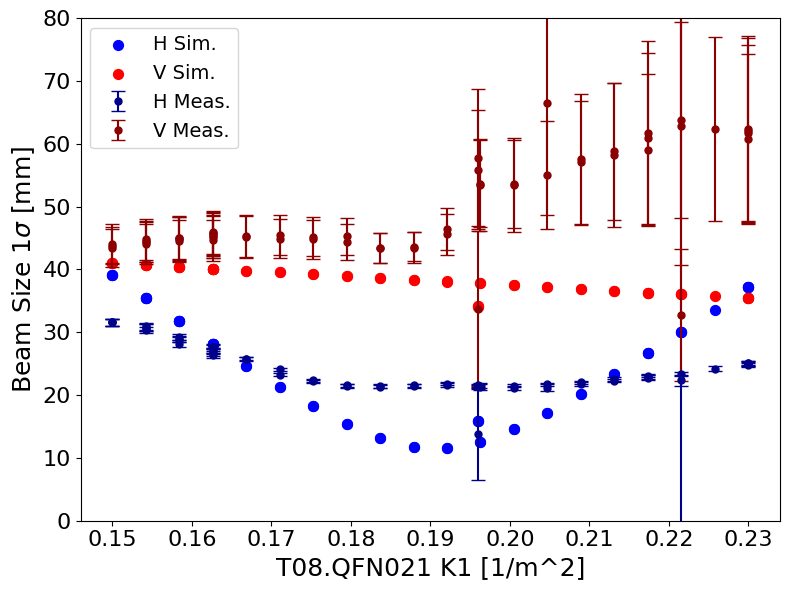

In [25]:
start = pd.to_datetime('2023-10-28 21:06:00.00')
end = pd.to_datetime('2023-10-28 21:19:00.00')

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
magnet  = "T08.QFN021/MEAS.PULSE"
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigH_meas, merged_df_filtered.sigH_meas_error, label='H Meas.', fmt='o', capsize=5, ls="", markersize=5, c="darkblue")
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigV_meas, merged_df_filtered.sigV_meas_error, label='V Meas.', marker='o',capsize=5, ls="", markersize=5, c="darkred")
ax.scatter(df_sim_filtered.Quad_K1_5, sigma_func(df_sim_filtered.FWHM_H)*1000, marker='o', label='H Sim.', s=50, c="b")
ax.scatter(df_sim_filtered.Quad_K1_5, sigma_func(df_sim_filtered.FWHM_V)*1000, marker='o', label='V Sim.', s=50, c="r")

ax.set_ylim(0,80)
ax.set_xlabel(f"{magnet.split('/')[0]} K1 [1/m^2]")
ax.set_ylabel(r"Beam Size 1$\sigma$ [mm]")
ax.legend()

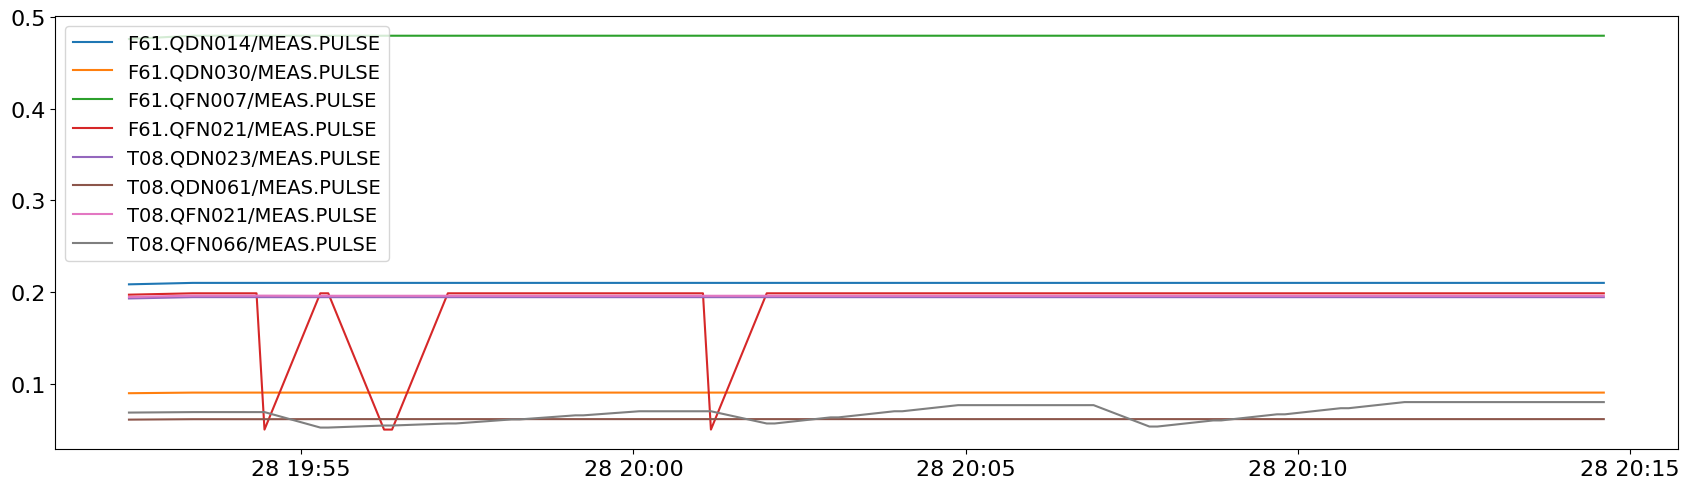

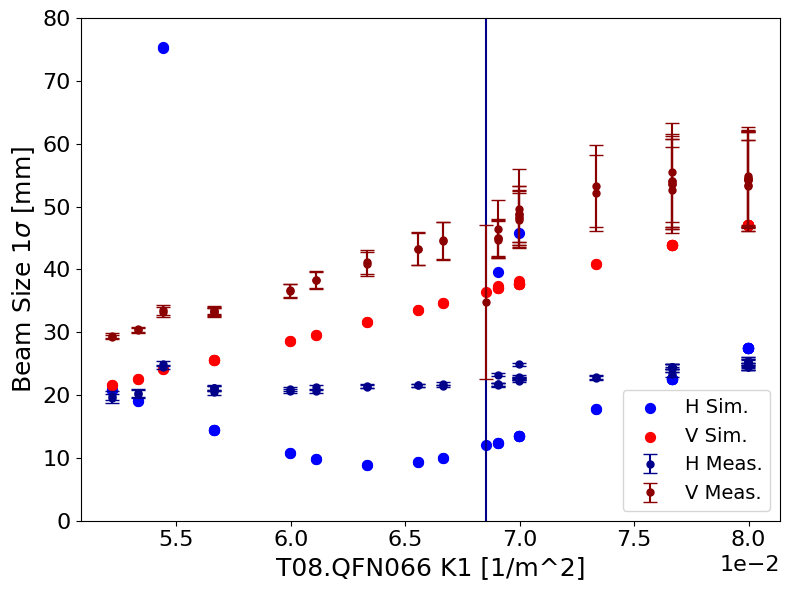

In [26]:
start = pd.to_datetime('2023-10-28 19:52:00.00')
end = pd.to_datetime('2023-10-28 20:15:00.00')


fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

magnet  = "T08.QFN066/MEAS.PULSE"
for magnet in merged_df_filtered.columns[6:]:
    ax.plot(merged_df_filtered.timestamp, merged_df_filtered[magnet],label=f"{magnet}")
ax.legend()

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
magnet  = "T08.QFN066/MEAS.PULSE"
magnet_sim = "Quad_K1_8"
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigH_meas, merged_df_filtered.sigH_meas_error, label='H Meas.', fmt='o', capsize=5, ls="", markersize=5, c="darkblue")
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigV_meas, merged_df_filtered.sigV_meas_error, label='V Meas.', marker='o',capsize=5, ls="", markersize=5, c="darkred")
ax.scatter(df_sim_filtered[magnet_sim], sigma_func(df_sim_filtered.FWHM_H)*1000, marker='o', label='H Sim.', s=50, c="b")
ax.scatter(df_sim_filtered[magnet_sim], sigma_func(df_sim_filtered.FWHM_V)*1000, marker='o', label='V Sim.', s=50, c="r")

ax.set_ylim(0,80)
ax.set_xlabel(f"{magnet.split('/')[0]} K1 [1/m^2]")
ax.set_ylabel(r"Beam Size 1$\sigma$ [mm]")
ax.legend()

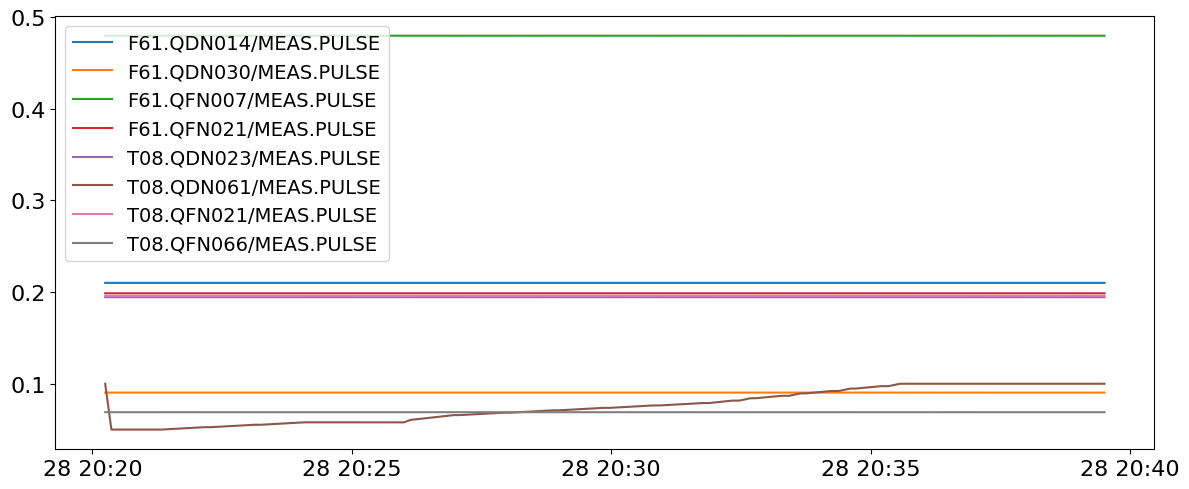

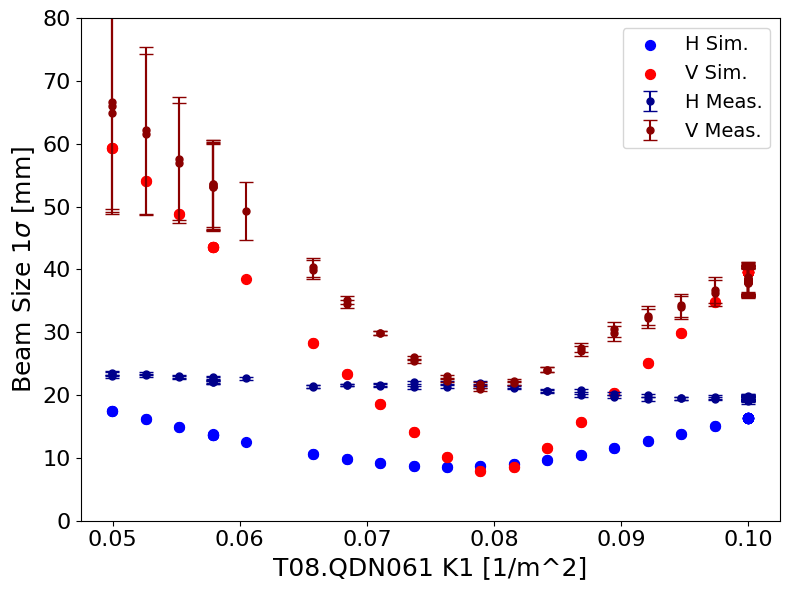

In [27]:
start = pd.to_datetime('2023-10-28 20:20:00.00')
end = pd.to_datetime('2023-10-28 20:40:00.00')


fig, ax = plt.subplots(figsize=(12,5), tight_layout=True)

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

magnet  = "T08.QFN066/MEAS.PULSE"
for magnet in merged_df_filtered.columns[6:]:
    ax.plot(merged_df_filtered.timestamp, merged_df_filtered[magnet],label=f"{magnet}")
ax.legend()

merged_df_filtered = merged_df[(merged_df.timestamp >= start) & (merged_df.timestamp <= end)]
df_sim_filtered = df_sim[(df_sim.Timestamp >= start) & (df_sim.Timestamp <= end)]

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
magnet  = "T08.QDN061/MEAS.PULSE"
magnet_sim = "Quad_K1_7"
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigH_meas, merged_df_filtered.sigH_meas_error, label='H Meas.', fmt='o', capsize=5, ls="", markersize=5, c="darkblue")
ax.errorbar(merged_df_filtered[magnet], merged_df_filtered.sigV_meas, merged_df_filtered.sigV_meas_error, label='V Meas.', marker='o',capsize=5, ls="", markersize=5, c="darkred")
ax.scatter(df_sim_filtered[magnet_sim], sigma_func(df_sim_filtered.FWHM_H)*1000, marker='o', label='H Sim.', s=50, c="b")
ax.scatter(df_sim_filtered[magnet_sim], sigma_func(df_sim_filtered.FWHM_V)*1000, marker='o', label='V Sim.', s=50, c="r")

ax.set_ylim(0,80)
ax.set_xlabel(f"{magnet.split('/')[0]} K1 [1/m^2]")
ax.set_ylabel(r"Beam Size 1$\sigma$ [mm]")
ax.legend()